In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import cython
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import pickle
import skopt

In [2]:
g_ket = basis(5,0)
u_ket = basis(5,1)
x_ket = basis(5,2)
a_ket = basis(5,3)
b_ket = basis(5,4)

g_bra = g_ket.dag()
u_bra = u_ket.dag()
x_bra = x_ket.dag()
a_bra = a_ket.dag()
b_bra = b_ket.dag()

g_id = g_ket*g_bra
u_id = u_ket*u_bra
x_id = x_ket*x_bra
a_id = a_ket*a_bra
b_id = b_ket*b_bra

gx_swap = x_ket*g_bra
ux_swap = x_ket*u_bra

spont_decay = b_ket*x_bra
cav_decay = a_ket*g_bra

H_cav = -(gx_swap + gx_swap.dag())
H_rabi = -1/2*(ux_swap + ux_swap.dag())
H_atom = u_id + g_id

opts = Options(rhs_reuse=True)

gamma = 2*np.pi

In [3]:
STEPS_PER_SEC = 100
def create_time(pulse_time):
    num_steps1 = round(STEPS_PER_SEC*pulse_time + 1)
    if num_steps1 < 1001:
        num_steps1 = 1001
        
    t_res = 2
    int_time1 = round(pulse_time, t_res)*10**t_res
    t1 = np.linspace(0, int_time1, num_steps1)
    t1 /= 10**t_res

    added_time = 1/gamma

    num_steps2 = round(STEPS_PER_SEC*added_time + 1)
    if num_steps2 < 1001:
        num_steps2 = 1001
    t_res = 2
    int_time2 = round(pulse_time + added_time, t_res)*10**t_res
    t2 = np.linspace(t1[-1], int_time2, num_steps1)
    t2 /= 10**t_res

    return [t1, t2]

In [4]:
def save_obj(object, name):
    with open(name+'.pickle', 'wb') as f:
        print(name+'.pickle')
        pickle.dump(object, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_obj(file):
    with open(file, 'rb') as f:
        return pickle.load(f)

In [5]:
NUM_GS = 20
NUM_TIMES = 20

g_min = 1
g_max = 20
g_ratios=np.linspace(g_min, g_max, NUM_GS)

t_min=0.5
t_max=20
t_min_idx = t_min/gamma
t_max_idx = t_max/gamma
pulse_times = np.linspace(t_min_idx, t_max_idx, NUM_TIMES)

kappas = [0.01, 0.1, 1]
kappa=2*np.pi
kappa_str=1

current_kappa = kappa
current_time = pulse_times[0]

In [6]:
def find_efficiency(g_ratio, omega, delta, kappa, time, psi0=u_ket, pulse_shape='sin'):

    g0 = g_ratio*gamma
    omega *= 2*np.pi
    delta *= 2*np.pi
    
    t1, t2 = create_time(time)

    H_args = {
        'g0': g0,
        'omega': omega,
        'delta': delta,
        'wSTIRAP': np.pi/time,
        'T': time
    }

    global current_kappa
    global current_time
    if kappa != current_kappa or time != current_kappa:
        rhs_clear()
        opts.rhs_reuse = False
        current_kappa = kappa
        current_time = time

    c_ops = [np.sqrt(kappa*gamma*2)*cav_decay, np.sqrt(gamma*2)*spont_decay]

    if pulse_shape == 'sin':
        pulse = 'omega*np.sin(wSTIRAP*t)**2'
    else:
        pulse = 'omega'
    
    H = [[H_cav, 'g0'], [H_rabi, pulse], [H_atom, 'delta']]

    result1 = mesolve(H, psi0, t1, c_ops, options=opts, args=H_args)
    H_args['omega'] = 0
    #result2 = mesolve(H, result1.states[-1], t2, c_ops, options=opts, args=H_args)
    opts.rhs_reuse = True

    return expect(a_id, result1.states[-1])

In [7]:
def optimiser(inputs):
    g_ratio, omega_0, delta_0, kappa, time = inputs

    omg_res = [300, 100, 30, 10, 3, 1, 0.3, 0.1]

    init_eff = find_efficiency(g_ratio, omega_0, delta_0, kappa, time)

    def find_eff(omega):
        return find_efficiency(g_ratio, omega, delta_0, kappa, time)
    
    for res in omg_res:

        new_step = 0
        finished = False

        while not finished:

            if new_step == 0:
                temp_effs = [init_eff, find_eff(omega_0 - res), find_eff(omega_0 + res)]
            elif new_step == 1:
                temp_effs = [init_eff, temp_effs[0], find_eff(omega_0 + res)]
            else:
                temp_effs = [init_eff, find_eff(omega_0 - res), temp_effs[0]]
            
            init_eff = max(temp_effs)

            if np.argmax(temp_effs) == 0:
                finished = True
            elif np.argmax(temp_effs) == 1:
                new_step = -1
                omega_0 -= res
            else:
                new_step = 1
                omega_0 += res
            
        omega_0 = abs(omega_0)

    def neg_eff(omg):
        return -find_eff(omg[0])

    op_result = skopt.gp_minimize(neg_eff, [[0.95*omega_0, 1.05*omega_0]], x0=[omega_0], n_calls=12)
    omega_0 = op_result.x[0]
    final_eff = -op_result.fun

    return {
        'g_ratio': g_ratio,
        'pulse_time': time,
        'omega': omega_0,
        'delta': delta_0,
        'kappa': kappa,
        'efficiency': final_eff
    }

In [8]:
total_cores = multiprocessing.cpu_count()
if total_cores > 60:
    num_cores = 60
else:
    num_cores = total_cores

In [9]:

first_time = True
input_args = []
output_list = []

for j in range(len(pulse_times)):
    input_args.append([[g_ratios[k], 100, 0, kappa, pulse_times[j]]for k in range(len(g_ratios))])

for input_set in input_args:

    if not first_time:

        for k in range(len(g_ratios)):
            input_set[k][1] = processed_list[k]['omega']
    
    if __name__ == "__main__":
        inputs = tqdm(input_set)
        processed_list = Parallel(n_jobs=num_cores)(delayed(optimiser)(i) for i in inputs)
        output_list.append(processed_list)
        save_obj(output_list, f'time_[{0}gamma^-1,{1}gamma^-1]_g_[{2},{3}]_kappa={4}_sin^2'.format(t_min,t_max,g_min,g_max,kappa_str))
    first_time = False



100%|██████████| 20/20 [02:23<00:00,  7.16s/it]


time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle


100%|██████████| 20/20 [02:16<00:00,  6.81s/it]


time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle


100%|██████████| 20/20 [02:15<00:00,  6.76s/it]


time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle


100%|██████████| 20/20 [02:19<00:00,  6.95s/it]


time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle


100%|██████████| 20/20 [01:56<00:00,  5.84s/it]


time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle


100%|██████████| 20/20 [01:59<00:00,  5.97s/it]


time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle


100%|██████████| 20/20 [01:58<00:00,  5.92s/it]


time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle


100%|██████████| 20/20 [01:59<00:00,  5.97s/it]


time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle


100%|██████████| 20/20 [02:01<00:00,  6.05s/it]


time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle


100%|██████████| 20/20 [01:49<00:00,  5.49s/it]


time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle


100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle


100%|██████████| 20/20 [01:27<00:00,  4.36s/it]


time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle


100%|██████████| 20/20 [01:41<00:00,  5.06s/it]


time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle


100%|██████████| 20/20 [00:59<00:00,  2.97s/it]


time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle


100%|██████████| 20/20 [01:17<00:00,  3.85s/it]


time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle


100%|██████████| 20/20 [04:50<00:00, 14.52s/it]


time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle


100%|██████████| 20/20 [01:01<00:00,  3.09s/it]


time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle


100%|██████████| 20/20 [01:14<00:00,  3.72s/it]


time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle


100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle


100%|██████████| 20/20 [01:38<00:00,  4.94s/it]


time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle


/var/folders/t7/7ztd24f11m79mgqy8dd_m8r40000gn/T/ipykernel_25777/4047704329.py:26: UserWarning: No contour levels were found within the data range.
  cs1 = a1.contour(X,Y, diff_effs, [0], colors='k')


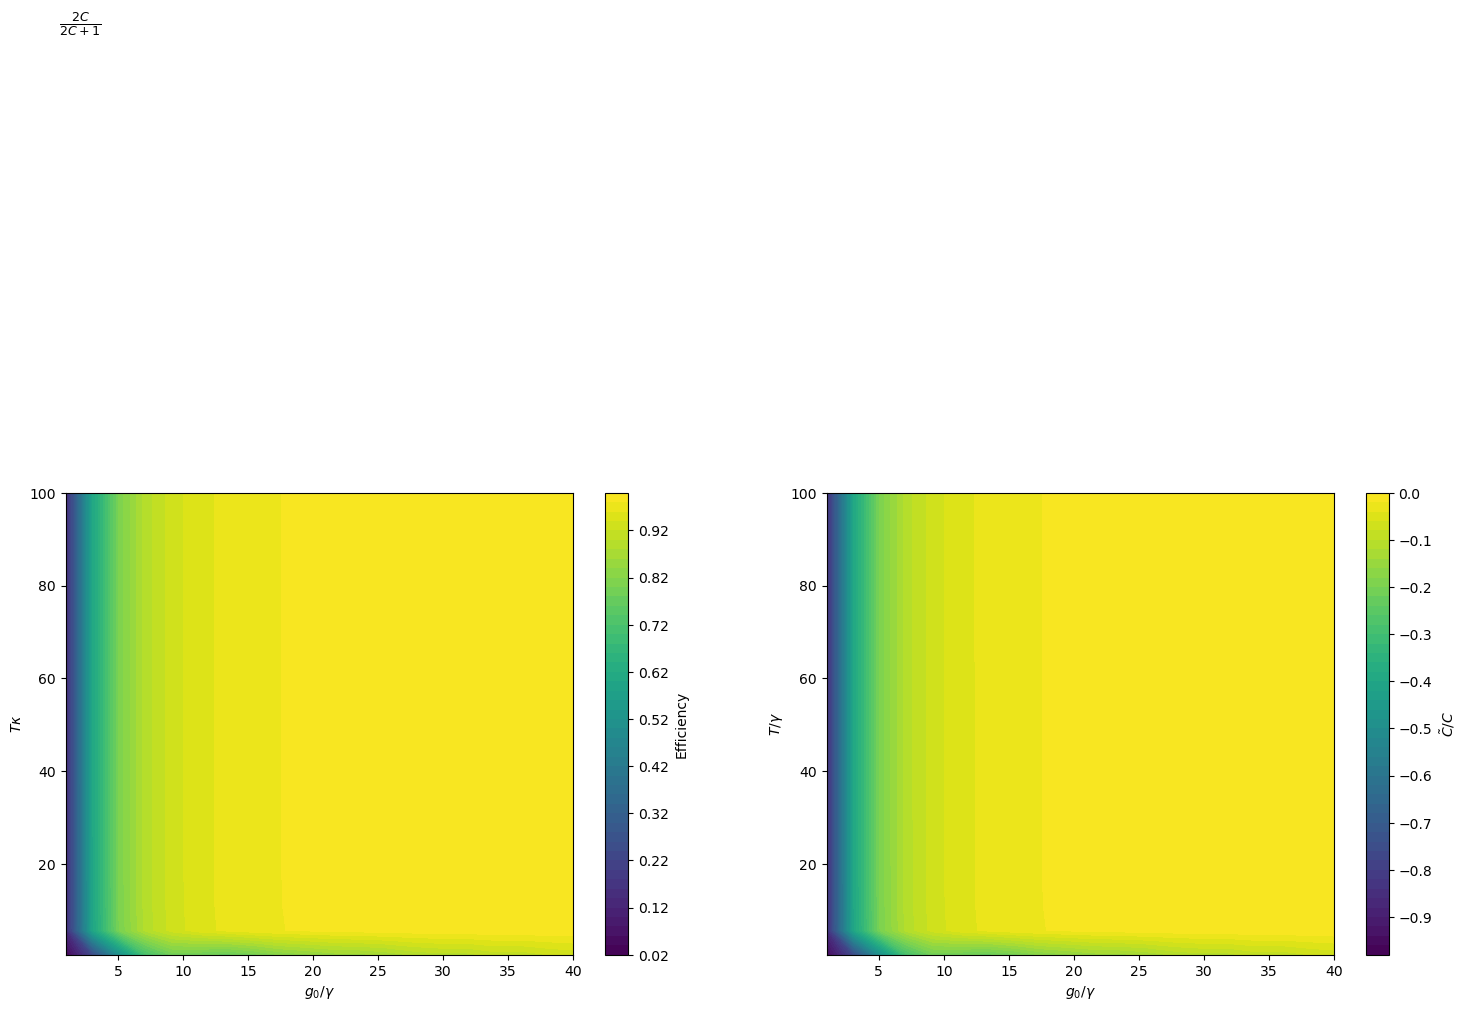

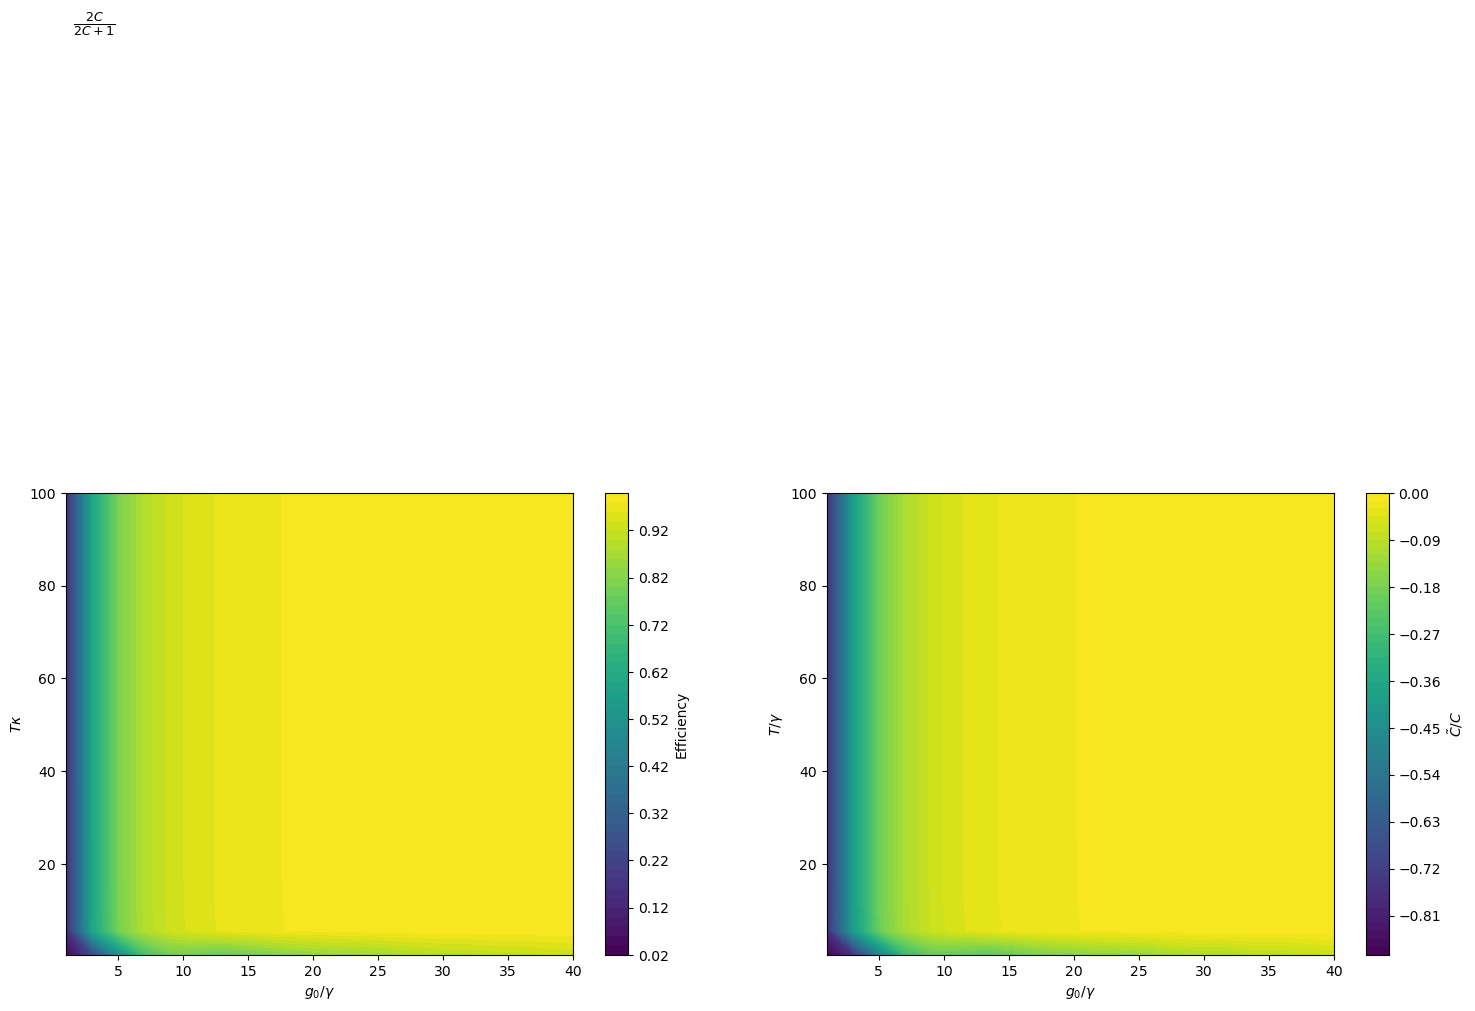

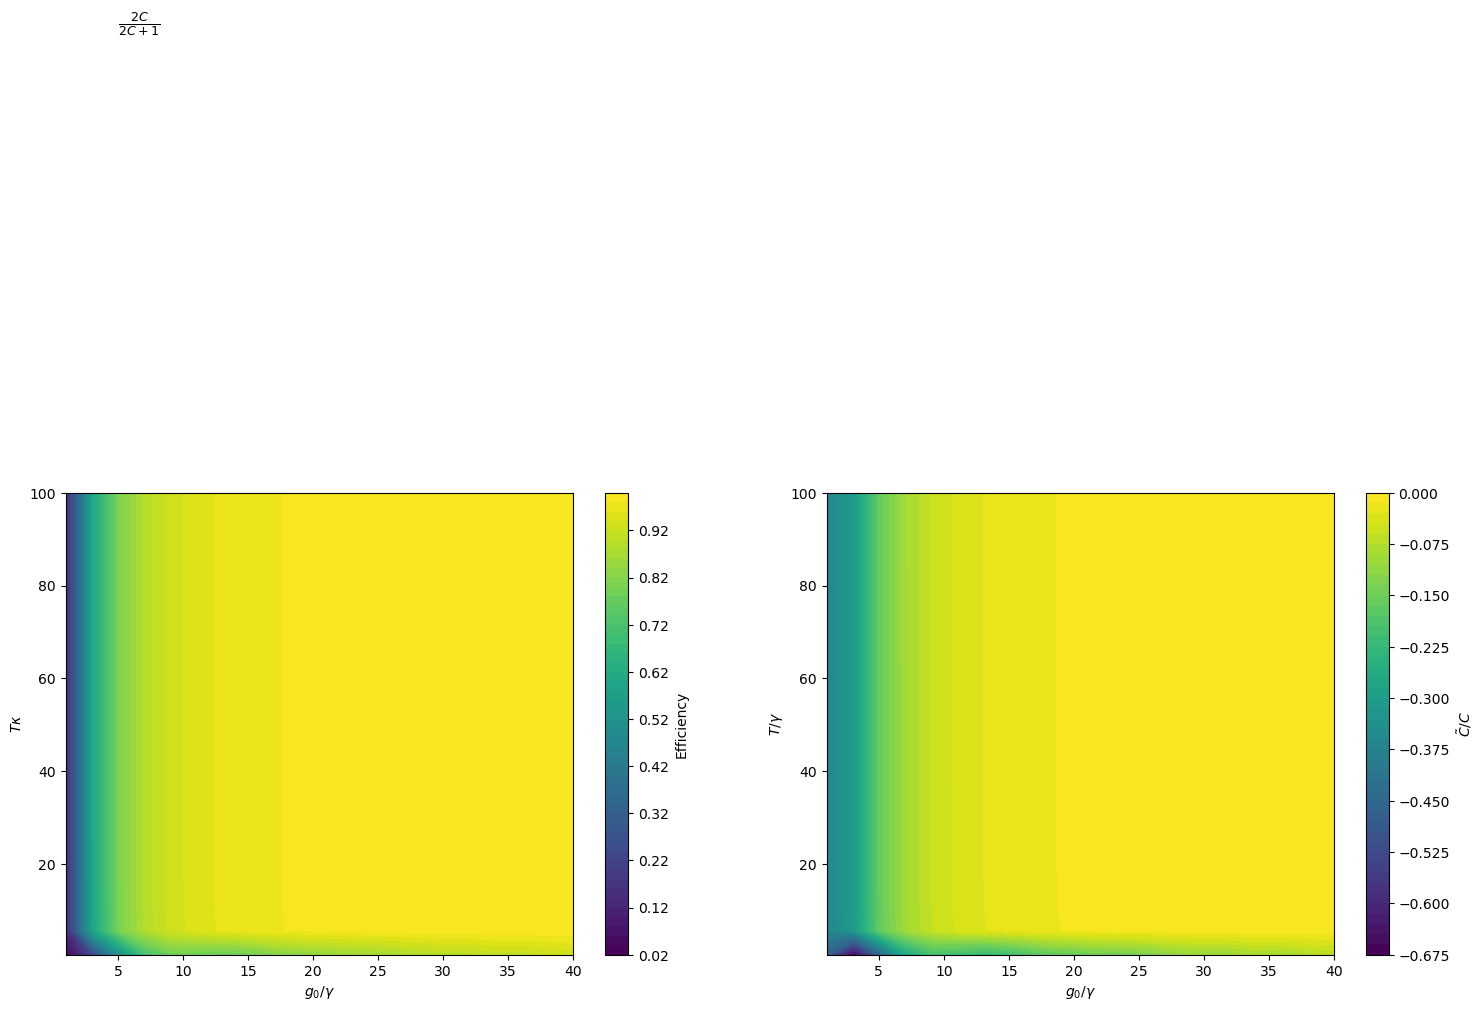

In [17]:
NUM_CONTS = 60
times = [time*gamma for time in pulse_times]

def C(g_ratio, kappa):
    return g_ratio**2/(2*kappa)

load_obj_str='time_[{0}gamma^-1,{1}gamma^-1]_g_[{2},{3}]_kappa={4}_sin^2.pickle'.format(t_min,t_max,g_min,g_max,kappa_str)

for kappa in kappas:
    data = load_obj('time_[0gamma^-1,1gamma^-1]_g_[2,3]_kappa=4_sin^2.pickle')

    effs = [[data[j][k]['efficiency'] for k in range(len(g_ratios))] for j in range(len(times))]
    bench = [[2*C(g, kappa)/(2*C(g,kappa)+1) for g in g_ratios] for t in times]
    diff_effs = [[effs[j][k] - bench[j][k] for k in range(len(g_ratios))] for j in range(len(times))]
    C_ratios = [[effs[j][k]/(2*C(g_ratios[k], kappa)*(1-effs[j][k])) for k in range(len(g_ratios))] for j in range(len(g_ratios))]

    X, Y = np.meshgrid(g_ratios, times)
    fig,[a1,a2] = plt.subplots(1,2)
    fig.set_size_inches(18,6)

    cp1 = a1.contourf(X,Y, effs, levels=NUM_CONTS)
    cb1 = fig.colorbar(cp1)
    cb1.set_label('Efficiency')
    a1.set_xlabel('$g_0/\gamma$')
    a1.set_ylabel('$T \kappa$')
    cs1 = a1.contour(X,Y, diff_effs, [0], colors='k')
    a1.text(5*np.sqrt(kappa), 200, '$\\frac{2C}{2C+1}$', fontsize=13, color='k')

    cp2 = a2.contourf(X,Y, diff_effs,levels=NUM_CONTS)
    cb2 = fig.colorbar(cp2)
    cb2.set_label('$\\tilde{C}/C$')
    a2.set_xlabel('$g_0/\gamma$')
    a2.set_ylabel('$T/\gamma$')


